# Petermann 3D Friction Inverse

Use the outline created in PetermannOutline to run an inverse problem solving for the basal friction that minimizes the misfit between the modeled and observed velocities

## Setup

Load in mesh and pull raster data

In [10]:
import sys 
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import rioxarray as rxr
import xarray as xr
import rasterio

import geojson

import firedrake
import icepack
import icepack.plot

### Mesh

In [4]:
outline_fn = 'petermann_streamlines_evenspace_full.geojson'
fn=outline_fn.split('.')[0]

with open(outline_fn, 'r') as outline_file:
    outline = geojson.load(outline_file)

In [ ]:
if os.path.isfile(fn+'.msh'):
    pass
else:
    geometry = icepack.meshing.collection_to_geo(outline)

    with open('petermann_streamline_evenspace_full.geo', 'w') as geo_file:
        geo_file.write(geometry.get_code())
        
    !gmsh -2 -format msh2 -v 2 -o petermann_streamline_evenspace_full.msh petermann_streamline_evenspace_full.geo;

In [5]:
mesh2d = firedrake.Mesh(fn+'.msh')
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

### Load/Interpolate Raster Data

#### Reading Data
Here, you should define root_ddir as the directory containing the BedMachine, MEaSUREs, hillshade, and climate forcing files
All files except BedMachine can be found [here](https://drive.google.com/drive/folders/1vSetbOF5Iy26ETMAF_-VXlrqotyp_3EO?usp=sharing).
BedMachine and other file sources can be found here:
- [BedMachine](https://nsidc.org/data/idbmg4/versions/5)
- [MEaSUREs](https://nsidc.org/grimp)
- [Martos Geothermal heat flux](https://doi.pangaea.de/10.1594/PANGAEA.892973?format=html#download)
- [RACMO2 Surface Temperature/Surface Mass Balance](https://doi.org/10.5194/tc-10-2361-2016) (Need to email author Brice Noel for dataset)
- [Hillshade](https://drive.google.com/drive/folders/1vSetbOF5Iy26ETMAF_-VXlrqotyp_3EO?usp=sharing) (creator is Nicholas Holchuh)


In [2]:
### Reading Data
### Here, you should define root_ddir as the directory containing the BedMachine, MEaSUREs, hillshade, and climate forcing files

root_ddir = '/mnt/data01/Data/'

velocity_fn = glob.glob(root_ddir+'*vel*.nc')
ice_info_fn = glob.glob(root_ddir+'*BedMachine*.nc')
hillshade_fn = glob.glob(root_ddir+'*Hillshade*.nc') 
geothermal_fn = glob.glob(root_ddir+'*Martos*.nc')
racmo_fn = glob.glob(root_ddir+'*RACMO*.nc')

### Hillshade
hs = xr.open_dataset(hillshade_fn[0])

### Velocities
vx = rxr.open_rasterio(velocity_fn[0])[0,:,:]
vy = rxr.open_rasterio(velocity_fn[1])[0,:,:]
vz=vy.copy()
vz.values=np.zeros(np.shape(vy.values))
speed=np.sqrt(vx**2+vy**2)

### Glacial geometry
ice_bed_props = rxr.open_rasterio(ice_info_fn[0])
thickness = ice_bed_props['thickness'][0,:,:]
bed = ice_bed_props['bed'][0,:,:]
surface = ice_bed_props['surface'][0,:,:]

### Climate forcings
geothermal = xr.open_rasterio(geothermal_fn[0])[0,:,:]/1000
racmo = xr.open_dataset(racmo_fn[0])
surftemp = racmo['T2m_avg']
SMB = racmo['SMB_avg']

In [6]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='R', vdegree=0)
V = firedrake.VectorFunctionSpace(mesh, family='CG', dim=2, degree=2, vfamily='GL', vdegree=2)

h0 = icepack.interpolate_xr(thickness, Q)
s0 = icepack.interpolate_xr(surface, Q)
b = icepack.interpolate_xr(bed, Q)
u0 = icepack.interpolate_xr((vx, vy), V)

#q = firedrake.FunctionSpace(mesh2d, family='CG', degree=2)
#v = firedrake.VectorFunctionSpace(mesh2d, family='CG', degree=2)

#h0_2d = icepack.interpolate_xr(thickness, q)
#s0_2d = icepack.interpolate_xr(surface, q)
#b_2d = icepack.interpolate_xr(bed, q)
#u0_2d = icepack.interpolate_xr((vx, vy), v)

In [6]:
### Reading data
root_ddir = '/mnt/data01/Data/'

velocity_fn = glob.glob(root_ddir+'Greenland_Velocity/*.nc')
ice_info_fn = glob.glob(root_ddir+'Greenland_BedElevation/*.nc')[0]
hillshade_fn = glob.glob(root_ddir+'Greenland_Imagery/*.nc') 
hs = xr.open_dataset(hillshade_fn[0])

vx = rxr.open_rasterio(velocity_fn[0])[0,:,:]
vy = rxr.open_rasterio(velocity_fn[1])[0,:,:]
vz=vy.copy()
vz.values=np.zeros(np.shape(vy.values))

ice_bed_props = rxr.open_rasterio(ice_info_fn)
thickness = ice_bed_props['thickness'][0,:,:]
surface = ice_bed_props['surface'][0,:,:]
bed = ice_bed_props['bed'][0,:,:]

In [7]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='R', vdegree=0)
V = firedrake.VectorFunctionSpace(mesh, family='CG', dim=2, degree=2, vfamily='GL', vdegree=2)

q = firedrake.FunctionSpace(mesh2d, family='CG', degree=2)
v = firedrake.VectorFunctionSpace(mesh2d, family='CG', degree=2)

h0 = icepack.interpolate_xr(thickness, Q)
s0 = icepack.interpolate_xr(surface, Q)
b = icepack.interpolate_xr(bed, Q)
u0 = icepack.interpolate_xr((vx, vy), V)

#h0_2d = icepack.interpolate_xr(thickness, q)
#s0_2d = icepack.interpolate_xr(surface, q)
#b_2d = icepack.interpolate_xr(bed, q)
#u0_2d = icepack.interpolate_xr((vx, vy), v)

### Plotting Functions

In [8]:
def subplots(*args, **kwargs):
    zoom = kwargs.get("zoom",0)
    figsize = kwargs.get("figsize",(8,8))
    
    fig, ax = plt.subplots(figsize=figsize)
    im1=ax.imshow(hs['hillshade'].values,
                  extent=[hs['x'].values.min(),hs['x'].values.max(),hs['y'].values.min(),hs['y'].values.max()],
                  cmap='Greys_r', vmin=0,vmax=200,origin='upper')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    if zoom == -1:
        ax.set_ylim([-1.6e6,-1e6]);
        ax.set_xlim([-0.325e6,0.1e6]);
    elif zoom == 0:
        ax.set_ylim([-1.55e6,-.9e6]);
        ax.set_xlim([-0.3e6,0.05e6]);
    elif zoom == 1:
        ax.set_ylim(-1.1e6,-0.9e6);
        ax.set_xlim(-3e5,-1.5e5);

    ax.set_aspect('equal')
    
    return fig, ax

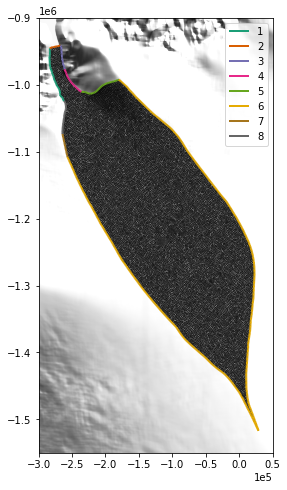

In [11]:
fig,ax = subplots(zoom=0)
kwargs = {
    'interior_kw': {'linewidth': .25},
    'boundary_kw': {'linewidth': 2}
}
icepack.plot.triplot(mesh2d, axes=ax, **kwargs);
ax.legend();

## Modeling

In [12]:
T = firedrake.Constant(260)
A = icepack.rate_factor(T)

### Friction Inverse

Use the InverseProblem class to solve for the basal friction from misfit between the modeled and observed velocity, first find a smoothed out driving stress over the domain

In [13]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m
)
from firedrake import Constant, sqrt, inner, grad, dx

α = Constant(10e3)
τ = firedrake.Function(V)
τ_d = -ρ_I * g * h0 *firedrake.as_vector([grad(s0)[0],grad(s0)[1]])
misfit = 0.5 * inner(τ - τ_d, τ - τ_d) * dx
smoothness = 0.5 * α ** 2 * inner(grad(τ), grad(τ)) * dx
J = misfit + smoothness
F = firedrake.derivative(J, τ)
firedrake.solve(F == 0, τ)

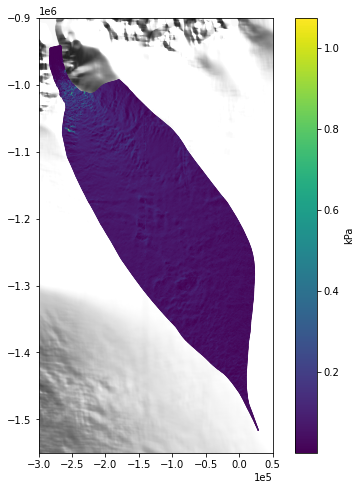

In [14]:
from firedrake import sqrt, tr

#effective_stress = firedrake.project(1e3 * sqrt(inner(τ_d, τ_d) + tr(τ_d)**2), Q)

effective_stress = firedrake.interpolate(τ_d,V)
fig,ax = subplots()
colors = icepack.plot.tripcolor(icepack.depth_average(effective_stress), axes=ax)
fig.colorbar(colors, label='kPa');

Calculate a rough, constant estimate of the friction coefficient `C0` (estimate basal friction coefficient takes up half the driving stress, set coefficient to 0 for floating ice)

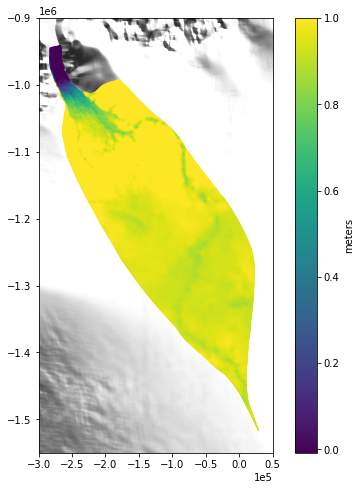

In [15]:
p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
p_I = ρ_I * g * h0
ϕ = 1 - p_W / p_I
C_est = sqrt(inner(τ, τ)) / sqrt(inner(u0, u0))
fraction = Constant(0.5)

expr = ϕ * fraction * C_est ** (1 / m)

C_0 = firedrake.interpolate(expr, Q)
area = firedrake.assemble(Constant(1.0) * dx(mesh))
C_0 = Constant(firedrake.assemble(C_0 * dx) / area)

pw = firedrake.interpolate(ϕ,Q)
fig,ax = subplots()
colors = icepack.plot.tripcolor(icepack.depth_average(pw), axes=ax)
fig.colorbar(colors, label='meters');

Parametrize friction by exp(theta) to scale friction but keep positive

In [16]:
import icepack.models.hybrid
def friction(**kwargs):
    u = kwargs["velocity"]
    θ = kwargs["log_friction"]
    h0 = kwargs["thickness"]
    s0 = kwargs["surface"]
    
    p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
    p_I = ρ_I * g * firedrake.max_value(1,h0)
    ϕ = 1 - p_W / p_I
    
    C = ϕ * C_0 * firedrake.exp(θ)
    return icepack.models.friction.bed_friction(velocity=u, friction=C)

In [17]:
model = icepack.models.HybridModel(friction=friction)
degree = 4
opts = {
    "dirichlet_ids": [5,6,7,8],
    "side_wall_ids": [1,3,4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    "form_compiler_parameters": {
        "quadrature_degree": degree
    }
}
solver = icepack.solvers.FlowSolver(model, **opts)

In [18]:
θ = firedrake.Function(Q)

In [19]:
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    log_friction=θ
)

(<Figure size 1152x288 with 6 Axes>,
 array([<AxesSubplot:title={'center':'Observed Velocity'}, xlabel='distance along centerline', ylabel='Velocity (m/s)'>,
        <AxesSubplot:title={'center':'Modeled Velocity'}, xlabel='distance along centerline'>,
        <AxesSubplot:title={'center':'Modeled-Observed'}, xlabel='distance along centerline'>],
       dtype=object))

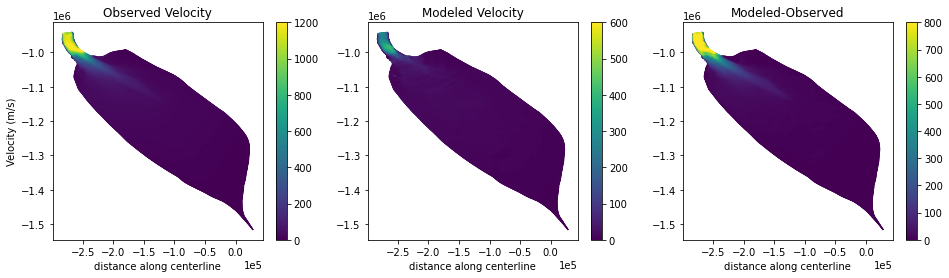

In [20]:
import icepack.plot
def u_difference_plot(u0,u,**kwargs):
    vmin1 = kwargs.get("vmin1",0)
    vmax1 = kwargs.get("vmax1",1200)
    vmin2 = kwargs.get("vmin2",0)
    vmax2 = kwargs.get("vmax2",600)
    vmin3 = kwargs.get("vmin3",0)
    vmax3 = kwargs.get("vmax3",800)
    
    fig,ax = plt.subplots(1,3,figsize=(16,4))
    im1=firedrake.tripcolor(icepack.depth_average(u0),axes=ax[0],vmin=vmin1,vmax=vmax1);
    im2=firedrake.tripcolor(icepack.depth_average(u),axes=ax[1],vmin=vmin1,vmax=vmax2);
    im3=firedrake.tripcolor(icepack.depth_average(firedrake.interpolate(u-u0,V)),vmin=vmin3,vmax=vmax3,axes=ax[2]);
    
    ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.colorbar(im1,ax=ax[0])
    plt.colorbar(im2,ax=ax[1])
    plt.colorbar(im3,ax=ax[2])
    
    ax[0].set_ylabel('Velocity (m/s)');
    ax[0].set_title('Observed Velocity');
    ax[1].set_title('Modeled Velocity');
    ax[2].set_title('Modeled-Observed');
    
    ax[0].set_xlabel('distance along centerline')
    ax[1].set_xlabel('distance along centerline')
    ax[2].set_xlabel('distance along centerline')
    
    return fig,ax
    
u_difference_plot(u0,u)

Define the simulation, loss functional, and the regularization functional for the `StatisticsProblem`

In [21]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0,
        thickness=h0,
        surface=s0,
        fluidity=A,
        log_friction=θ,
    )

σx = Constant(5.0)
σy = Constant(5.0)
def loss_functional(u):
    δu = u - u0
    return 0.5 / Constant(area) * ((δu[0] / σx)**2 + (δu[1] / σy)**2) * dx

L = Constant(10e3)
def regularization(θ):
    return 0.5 * L**2 / Constant(area) * inner(grad(θ), grad(θ)) * dx

In [22]:
from icepack.statistics import StatisticsProblem, MaximumProbabilityEstimator

problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)

In [ ]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=50,
    verbose = 0
)
θ = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     2.962098e+02   1.420407e-02                  1.420407e-02   


## Analysis

In [29]:
u = simulation(θ)
opt_bed_friction = firedrake.interpolate(friction(velocity=u0, thickness=h0, surface=s0, log_friction=θ),Q)
δu = firedrake.interpolate(sqrt(inner(u - u0, u - u0)), Q)

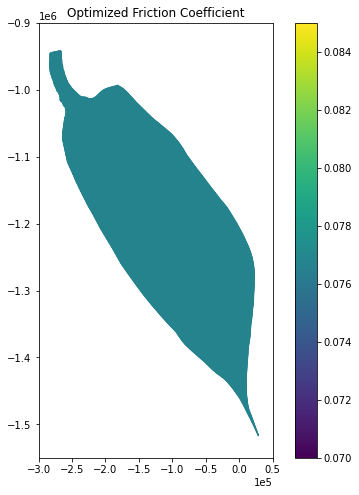

In [41]:
fig, ax = subplots()
colors = firedrake.tripcolor(icepack.depth_average(opt_bed_friction), vmin=0.07, vmax=0.085, axes=ax)
fig.colorbar(colors);
ax.set_title('Optimized Friction Coefficient');

In [ ]:
fig, ax = subplots()
colors = firedrake.tripcolor(opt_bed_friction, vmin=0, vmax = 30, axes=ax)
fig.colorbar(colors);
ax.set_title('Bed Friction');

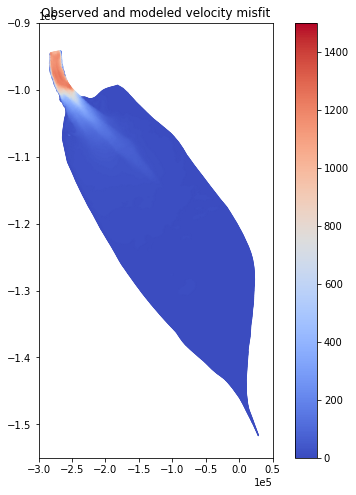

In [49]:
fig, ax = subplots()
colors = firedrake.tripcolor(icepack.depth_average(δu), vmin=0.0, vmax=1500, axes=ax,cmap='coolwarm')
ax.set_title('Observed and modeled velocity misfit')
fig.colorbar(colors);